# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from keras.datasets import mnist
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, merge
from keras.layers import Input, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.local import LocallyConnected2D
from keras.utils.np_utils import to_categorical

import os
import sys
import tarfile
import numpy as np
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve
from PIL import Image
from scipy.misc import imresize
from scipy import ndimage
import matplotlib.pyplot as plt
import h5py
import operator

%matplotlib inline

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


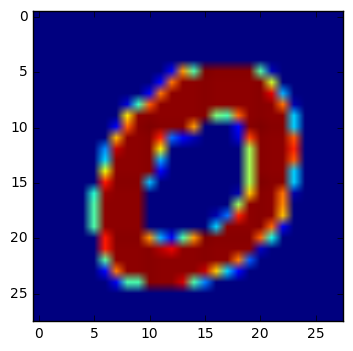

In [3]:
image = np.array(X_train[np.random.randint(X_train.shape[0]), :, :])

plt.figure()
plt.imshow(image)

In [4]:
# Don't run unless generating new data!

num_labels = 11 # 0-9 + blank
image_size = 28
new_image_size = 28

def seqLength(n):
    s = 1
    if n > 10:
        s += seqLength(n / 10)
    return s

def generateNewDataset(source_data, source_labels, sequences, max_sequence_length=5, option=1, insert_blanks=True):

    new_dataset = np.ndarray((sequences, 1, new_image_size, new_image_size), dtype=np.int8)
    new_labels = np.ndarray((sequences, num_labels, max_sequence_length), dtype=np.int8)
    sequence_lengths = np.ndarray((sequences, max_sequence_length), dtype=np.int8)
    
    # Support for option 2 below
    if option == 2:
        random_lengths = np.random.randint(1, max_sequence_length + 1, sequences)
    
    for sequence in range(sequences):

        # Option 1: Equal numbers of cases per class, except sequence_length
        if option == 1:
            number = np.random.randint(10 ** max_sequence_length)
            sequence_length = seqLength(number)

        # Option 2: Equal numbers of cases for each sequence_length - and each resized number
        if option == 2:
            sequence_length = random_lengths[sequence]
        
        # Save sequence length to return variable
        sequence_lengths[sequence, :] = 0
        sequence_lengths[sequence, sequence_length - 1] = 1
        
        # Randomly select samples from source data
        sample_indices = []
        for bar in range(sequence_length):
            sample_indices.append(np.random.randint(source_data.shape[0]))

        # Save label data from sources
        new_labels[sequence, :, :] = 0
        new_labels[sequence, 0, sequence_length:max_sequence_length] = 1 # Label "blank" classes
        for digit in range(sequence_length):
            new_labels[sequence, source_labels[sample_indices[digit]] + 1, digit] = 1

        # Pull the images from the original sources and concatenate
        sample = np.matrix(source_data[sample_indices[0], :, :])
        for character in sample_indices[1:]:
            sample = np.concatenate((sample, np.matrix(source_data[character, :, :])), axis=1)
            
        # Insert blanks to keep digits aligned
        if insert_blanks:
            for bar in range(max_sequence_length - sequence_length):
                sample = np.concatenate((sample, np.matrix([[0] * image_size] * image_size)), axis=1)
            
        # Resize sequence image to constant width
        new_image = imresize(sample, (new_image_size, new_image_size), interp='bilinear')
        
        # Append current sample to new data and label sets
        new_dataset[sequence, 0, :, :] = new_image
        
    return new_dataset, new_labels, sequence_lengths

new_train_dataset, new_train_labels, train_sequences = generateNewDataset(X_train, y_train, 5000000, 5, 1, True)
new_test_dataset, new_test_labels, test_sequences = generateNewDataset(X_test, y_test, 30000, 5, 1, True)

print("Generating sequence data complete.")
print(new_train_dataset.shape, new_train_labels.shape, train_sequences.shape)
print(new_test_dataset.shape, new_test_labels.shape, test_sequences.shape)

Generating sequence data complete.
(5000, 1, 28, 28) (5000, 11, 5) (5000, 5)
(30, 1, 28, 28) (30, 11, 5) (30, 5)


In [35]:
print(np.sum(new_train_labels, axis=0)) # Check distribution of classes
print("\n")
print(np.sum(train_sequences, axis=0)) # Check distribution of sequence lengths

[[     0    548   5065  50202 499113]
 [492771 492897 493405 487557 444618]
 [562559 562128 561580 556328 504790]
 [497234 496771 496023 492107 447744]
 [511250 510921 508887 506020 460438]
 [488280 487248 486689 481984 439078]
 [451408 450997 451687 447095 406590]
 [492828 492963 493540 488657 443633]
 [522042 522821 521004 516480 470587]
 [486983 487216 486752 482897 438424]
 [494645 495490 495368 490673 444985]]


[    548    4517   45137  448911 4500887]


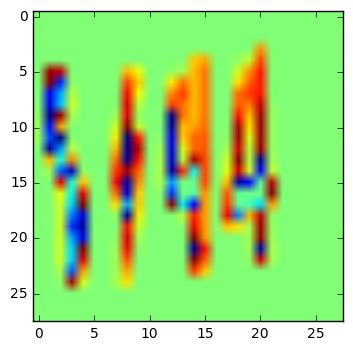

In [7]:
image = np.array(new_train_dataset[np.random.randint(new_train_dataset.shape[0]), 0, :, :])

plt.figure()
plt.imshow(image)

In [37]:
# Don't run unless saving a new batch of data!

pickle_file = 'MNISTseq28_xlg-3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': new_train_dataset,
    'train_labels': new_train_labels,
    'train_sequences': train_sequences,
    'test_dataset': new_test_dataset,
    'test_labels': new_test_labels,
    'test_sequences': test_sequences,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 4245320505


In [2]:
# Run this cell after the import statements if the sequence data is already pickled

pickle_file = 'MNISTseq28_xlg-3.pickle'
# Random numbers, with label for blank cases:                          'MNISTseq28_xlg-1.pickle'
# Random lengths, with label for blank cases:                          'MNISTseq28_xlg-2.pickle'
# Random numbers, with label for blank cases, and constant spacing:    'MNISTseq28_xlg-3.pickle'
# Random lengths, with label for blank cases, and constant spacing:    'MNISTseq28_xlg-4.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  train_sequences = save['train_sequences']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  test_sequences = save['test_sequences']
  del save  # hint to help gc free up memory

image_size = 28
# image_size = 64
num_labels = 11
max_sequence_length=5
num_channels = 1 # grayscale

print('Training set', train_dataset.shape, train_labels.shape, train_sequences.shape)
print('Test set', test_dataset.shape, test_labels.shape, test_sequences.shape)

Training set (5000000, 1, 28, 28) (5000000, 11, 5) (5000000, 5)
Test set (30000, 1, 28, 28) (30000, 11, 5) (30000, 5)


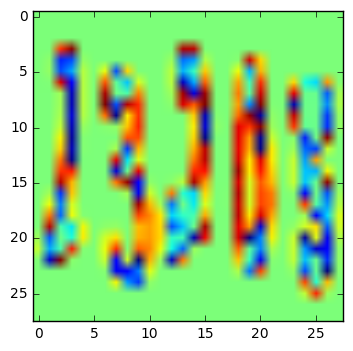

In [3]:
image = np.array(train_dataset[np.random.randint(train_dataset.shape[0]), 0, :, :])

plt.figure()
plt.imshow(image)

In [6]:
# Model adapted from "VGG-like convnet" at https://keras.io/getting-started/sequential-model-guide/
# and extended to mimic the Google Mult-digit classifier from the paper linked above

inputs = Input(shape=(num_channels, image_size, image_size))

c1 = Convolution2D(64, 5, 5, border_mode='same')(inputs)
a1 = Activation('relu')(c1)
mp1 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a1)
bn1 = BatchNormalization()(mp1)

c2 = Convolution2D(96, 5, 5, border_mode='same')(bn1)
a2 = Activation('relu')(c2)
mp2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a2)
do2 = Dropout(0.25)(mp2)
bn2 = BatchNormalization()(do2)

c3 = Convolution2D(128, 5, 5, border_mode='same')(bn2)
a3 = Activation('relu')(c3)
mp3 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a3)
do3 = Dropout(0.25)(mp3)
bn3 = BatchNormalization()(do3)

c4 = Convolution2D(160, 5, 5, border_mode='same')(bn3)
a4 = Activation('relu')(c4)
mp4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a4)
do4 = Dropout(0.25)(mp4)
bn4 = BatchNormalization()(do4)

c5 = Convolution2D(192, 5, 5, border_mode='same')(bn4)
a5 = Activation('relu')(c5)
mp5 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a5)
do5 = Dropout(0.25)(mp5)
bn5 = BatchNormalization()(do5)

c6 = Convolution2D(192, 5, 5, border_mode='same')(bn5)
a6 = Activation('relu')(c6)
mp6 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a6)
do6 = Dropout(0.25)(mp6)
bn6 = BatchNormalization()(do6)

c7 = Convolution2D(192, 5, 5, border_mode='same')(bn6)
a7 = Activation('relu')(c7)
mp7 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a7)
do7 = Dropout(0.25)(mp7)
bn7 = BatchNormalization()(do7)

c8 = Convolution2D(192, 5, 5, border_mode='same')(bn7)
a8 = Activation('relu')(c8)
mp8 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a8)
do8 = Dropout(0.25)(mp8)
bn8 = BatchNormalization()(do8)

fl = Flatten()(bn8)

d1 = Dense(1024)(fl)
a9 = Activation('relu')(d1)
do9 = Dropout(0.25)(a9)
bn9 = BatchNormalization()(do9)

d3 = Dense(max_sequence_length)(bn9)
bn10 = BatchNormalization()(d3)
L = Activation('softmax')(bn10) # <--- Sequence length representation

d4 = Dense(num_labels)(bn9)
bn11 = BatchNormalization()(d4)
S1 = Activation('softmax')(bn11) # First character/digit

d5 = Dense(num_labels)(bn9)
bn12 = BatchNormalization()(d5)
S2 = Activation('softmax')(bn12)

d6 = Dense(num_labels)(bn9)
bn13 = BatchNormalization()(d6)
S3 = Activation('softmax')(bn13)

d7 = Dense(num_labels)(bn9)
bn14 = BatchNormalization()(d7)
S4 = Activation('softmax')(bn14)

d8 = Dense(num_labels)(bn9)
bn15 = BatchNormalization()(d8)
S5 = Activation('softmax')(bn15)

clf = Model(input=inputs, output=[L, S1, S2, S3, S4, S5]) # Seq length + five channel output

clf.compile(loss='categorical_crossentropy', optimizer='adadelta', 
            metrics=['categorical_accuracy'])

clf.fit(train_dataset, [train_sequences, train_labels[:,:,0], train_labels[:,:,1], train_labels[:,:,2], 
                        train_labels[:,:,3], train_labels[:,:,4]], batch_size=100, 
                        nb_epoch=3, validation_split=0.006)

clf.save('MNIST-xlg3-2.h5')

Train on 4970000 samples, validate on 30000 samples
Epoch 1/3
4970000/4970000 [==============================] - 2052s - loss: 1.8843 - activation_10_loss: 0.0291 - activation_11_loss: 0.3627 - activation_12_loss: 0.4360 - activation_13_loss: 0.3494 - activation_14_loss: 0.4361 - activation_15_loss: 0.2710 - activation_10_categorical_accuracy: 0.9980 - activation_11_categorical_accuracy: 0.8977 - activation_12_categorical_accuracy: 0.8722 - activation_13_categorical_accuracy: 0.9026 - activation_14_categorical_accuracy: 0.8705 - activation_15_categorical_accuracy: 0.9274 - val_loss: 0.5462 - val_activation_10_loss: 1.1692e-04 - val_activation_11_loss: 0.1012 - val_activation_12_loss: 0.1370 - val_activation_13_loss: 0.1045 - val_activation_14_loss: 0.1189 - val_activation_15_loss: 0.0845 - val_activation_10_categorical_accuracy: 1.0000 - val_activation_11_categorical_accuracy: 0.9731 - val_activation_12_categorical_accuracy: 0.9609 - val_activation_13_categorical_accuracy: 0.9702 - val

In [13]:
def getAccuracy(clf, test_dataset, test_sequences, fiveDigit=True):
    pred = clf.predict(test_dataset)
    acc = 0
    for sample in range(len(test_sequences)):
        pred_length = pred[0][sample]
        index0, value0 = max(enumerate(pred_length), key=operator.itemgetter(1))
        pred_d1 = pred[1][sample]
        index1, value1 = max(enumerate(pred_d1), key=operator.itemgetter(1))
        pred_d2 = pred[2][sample]
        index2, value2 = max(enumerate(pred_d2), key=operator.itemgetter(1))
        pred_d3 = pred[3][sample]
        index3, value3 = max(enumerate(pred_d3), key=operator.itemgetter(1))
        pred_d4 = pred[4][sample]
        index4, value4 = max(enumerate(pred_d4), key=operator.itemgetter(1))
        if fiveDigit:
            pred_d5 = pred[5][sample]
            index5, value5 = max(enumerate(pred_d5), key=operator.itemgetter(1))

        if fiveDigit and (test_sequences[sample, index0] == 1 and test_labels[sample, index1, 0] == 1 and 
            test_labels[sample, index2, 1] == 1 and test_labels[sample, index3, 2] == 1 and 
            test_labels[sample, index4, 3] == 1 and test_labels[sample, index5, 4] == 1):
            acc += 1
        if not fiveDigit and (test_sequences[sample, index0] == 1 and test_labels[sample, index1, 0] == 1 and 
            test_labels[sample, index2, 1] == 1 and test_labels[sample, index3, 2] == 1 and 
            test_labels[sample, index4, 3] == 1):
            acc += 1
    return 1. * acc / len(test_sequences)

In [5]:
clf = load_model('MNIST-xlg3-1.h5') # xlg-3 dataset, conv: [48, 64, 128, 160...], dense: 1024, 3 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

29984/30000 [============================>.] - ETA: 0s
 [0.54409647638797765, 2.4852262387867085e-05, 0.11416944639484088, 0.11118109554151694, 0.12973993959873914, 0.11220691709319751, 0.07677422573827207, 1.0, 0.96726666666666672, 0.96626666666666672, 0.96389999999999998, 0.96783333333333332, 0.97836666666666672]

 0.8521333333333333


In [7]:
clf = load_model('MNIST-xlg3-2.h5') # xlg-3 dataset, conv: [64, 96, 128, 160...], dense: 1024, 3 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

30000/30000 [==============================] - 10s    

 [0.3996232834537824, 2.1997499996602226e-05, 0.07616748333324988, 0.087261265190442402, 0.086968110142648214, 0.086207487228016064, 0.062996940180783473, 1.0, 0.97916666666666663, 0.97629999999999995, 0.97636666666666672, 0.97463333333333335, 0.98243333333333338]

 0.8936333333333333


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** I first designed a multilayer convolutional network, based on the Keras documentation (https://keras.io/getting-started/sequential-model-guide/#examples), and made certain it performed well on single digits from the Keras MNIST dataset.

Next I modified the data sets to use random combinations of up to five samples from the MNIST data and added parallel softmax outputs in a similar fashion to the Google architecture linked above. This model was almost 80% accurate on 5-digit combinations and >95% per digit accuracy.

Adding in additional convoluational layers, to mimic the Google architecture fully, produced a network that takes significantly longer to train, but has 89.5% accuracy on 5-digit combinations and is ~98% accurate on each digit.

I tested a number of slight alterations and settled on only using one large dense layer after the convolutions.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** My final archecture uses eight convoluational layers, one large dense layers, and then a small dense layer for each of the six outputs (length of sequence and five digits). A complete printout of the design is below.

In [ ]:
clf = load_model('3_on_xlg-3i.h5')
clf.summary()

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** I trained my model using the adadelta optimizer. Researching similar image classification problems indicated that Adam and Adadelta are common choices for this type of application.

I tested generating my synthetic dataset a few different ways, but settled on randomly generating numbers between 0 and 99,999, using the length of that number to then grab a matching number of random samples from the training or test sets, concatenating those images together, then resizing the resulting image back to 28x28. In the cases where less than five digits were used, I inserted blank space into the image so that there is more consistency in the data. 5,000,000 new training samples were generated using the original training data and 30,000 new testing samples were generated using the original testing data.

Samples of generated images can be found below.

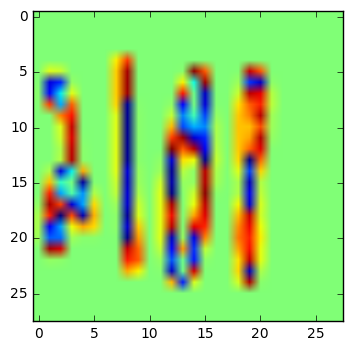

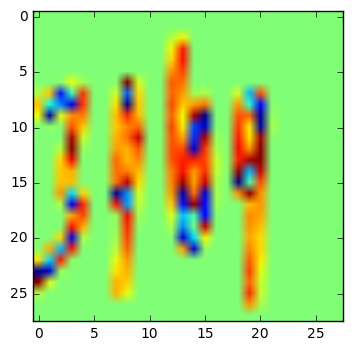

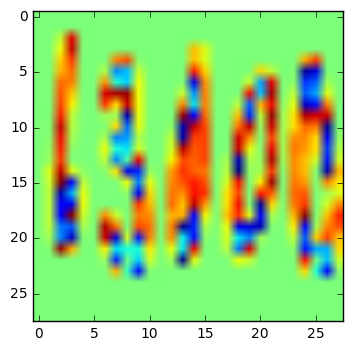

In [16]:
image = np.array(train_dataset[np.random.randint(train_dataset.shape[0]), 0, :, :])

plt.figure()
plt.imshow(image)

image = np.array(train_dataset[np.random.randint(train_dataset.shape[0]), 0, :, :])

plt.figure()
plt.imshow(image)

image = np.array(train_dataset[np.random.randint(train_dataset.shape[0]), 0, :, :])

plt.figure()
plt.imshow(image)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def get_SVHN(filename, expected_bytes, force=False):
  if force or not os.path.exists(filename):
    print('Downloading:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('Download Complete')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = get_SVHN('train.tar.gz', 404141560)
test_filename = get_SVHN('test.tar.gz', 276555967)
extra_filename = get_SVHN('extra.tar.gz', 1955489752)

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz


In [4]:
def extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders, "data extraction complete.")
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)
extra_folders = extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
train data extraction complete.
test already present - Skipping extraction of test.tar.gz.
test data extraction complete.
extra already present - Skipping extraction of extra.tar.gz.
extra data extraction complete.


In [7]:
# Don't run unless you need to generate a new set of dictionaries

def digitStruct_name(sample, hdf5_data):
    name_obj = hdf5_data['digitStruct']['name']
    name = ''.join([chr(value[0]) for value in hdf5_data[name_obj[sample][0]].value])
    return name

def digitStruct_bbox(sample, hdf5_data):
    def get_values(member, obj):
        value = []
        if obj.shape[0] > 1:
            for character in range(obj.shape[0]):
                value.append(int(hdf5_data[obj[character][0]][0][0]))
        else:
            value.append(int(obj[0][0]))
        box_info[member] = value

    box_info = {}
    box_info['label'] = []
    box_info['top'] = []
    box_info['left'] = []
    box_info['height'] = []
    box_info['width'] = []

    bbox = hdf5_data['digitStruct']['bbox'][sample]
    hdf5_data[bbox[0]].visititems(get_values)
    return box_info

def createDictionary(struct):
    dictionary = {}
    len_samples = struct['digitStruct']['name'].size
    for sample in range(len_samples):
        image_name = digitStruct_name(sample, struct)
        image_bbox = digitStruct_bbox(sample, struct)
        dictionary[image_name] = image_bbox
    return dictionary, len_samples

train_struct = h5py.File('TrainDigitStruct.mat')
train_dictionary, train_samples = createDictionary(train_struct)
print("Train dictionary complete.")
print("Train samples:", train_samples)

test_struct = h5py.File('TestDigitStruct.mat')
test_dictionary, test_samples = createDictionary(test_struct)
print("Test dictionary complete.")
print("Test samples:", test_samples)

extra_struct = h5py.File('ExtraDigitStruct.mat')
extra_dictionary, extra_samples = createDictionary(extra_struct)
print("Extra dictionary complete.")
print("Extra samples:", extra_samples)

Train dictionary complete.
Train samples: 33402
Test dictionary complete.
Test samples: 13068
Extra dictionary complete.
Extra samples: 202353


In [8]:
# Only run to save a new set of dictionaries

pickle_file = 'SVHN-dictionaries.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dictionary': train_dictionary,
        'test_dictionary': test_dictionary,
        'extra_dictionary': extra_dictionary,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 17739007


In [3]:
# Run to load dictionaries

pickle_file = 'SVHN-dictionaries.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dictionary = save['train_dictionary']
  test_dictionary = save['test_dictionary']
  extra_dictionary = save['extra_dictionary']
  del save  # hint to help gc free up memory

print("Train dictionary:", len(train_dictionary))
print("Test dictionary:", len(test_dictionary))
print("Extra dictionary:", len(extra_dictionary))

Train dictionary: 33402
Test dictionary: 13068
Extra dictionary: 202353


In [4]:
# Don't run unless you need to generate a new data set

image_size = 32
# pixel_depth = 255.0
pixel_channels = 1
max_sequence_length=4
num_labels = 11

def load_images(folder, dictionary):
    image_files = os.listdir(folder)

    dataset = np.ndarray(shape=(len(image_files), pixel_channels, image_size, image_size), dtype=np.int32)
    labels = np.ndarray(shape=(len(image_files), num_labels, max_sequence_length), dtype=np.int32)
    sequences = np.ndarray(shape=(len(image_files), max_sequence_length), dtype=np.int32)
    
    num_images = 0
    skipped_images = 0
    for image in image_files:
        if image in dictionary:
            label_sequence = dictionary[image]['label']
        else:
            label_sequence = None
            skipped_images += 1
            
        if len(label_sequence) > max_sequence_length:
            label_sequence = None
            skipped_images += 1
            print("Image", image, "has too many digits!")
        
        if label_sequence != None and len(label_sequence) > 0:
            image_file = os.path.join(folder, image)
            # image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            image_data = ndimage.imread(image_file, flatten=True)
            resized_image = imresize(image_data, (image_size, image_size), interp='bilinear')
            dataset[num_images, 0, :, :] = resized_image
            
            labels[num_images, :, :] = 0
            if len(label_sequence) < max_sequence_length:
                labels[num_images, 0, len(label_sequence):] = 1 # Blank class labels
            for index in range(len(label_sequence)):
                labels[num_images, label_sequence[index], index] = 1
                
            sequences[num_images, :] = 0
            sequences[num_images, len(label_sequence) - 1] = 1
            
            num_images = num_images + 1
        
    print('\nSkipped images:', skipped_images)
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset), "\n")

    dataset = dataset[0:num_images, :, :, :]
    labels = labels[0:num_images, :, :]
    sequences = sequences[0:num_images, :]

    return dataset, labels, sequences

train_dataset, train_labels, train_sequences = load_images('train', train_dictionary)
test_dataset, test_labels, test_sequences = load_images('test', test_dictionary)
extra_dataset, extra_labels, extra_sequences = load_images('extra', extra_dictionary)
print("Done.")

Image 15958.png has too many digits!
Image 18263.png has too many digits!
Image 18944.png has too many digits!
Image 24041.png has too many digits!
Image 24552.png has too many digits!
Image 26699.png has too many digits!
Image 29930.png has too many digits!
Image 33229.png has too many digits!
Image 4111.png has too many digits!
Image 6739.png has too many digits!

Skipped images: 10
Full dataset tensor: (33402, 1, 32, 32)
Mean: 138.103694992
Standard deviation: 69.002738888 

Image 2999.png has too many digits!
Image 7314.png has too many digits!

Skipped images: 2
Full dataset tensor: (13068, 1, 32, 32)
Mean: 126.770589865
Standard deviation: 72.9288685012 

Image 100119.png has too many digits!
Image 10111.png has too many digits!
Image 101591.png has too many digits!
Image 102560.png has too many digits!
Image 106078.png has too many digits!
Image 10779.png has too many digits!
Image 108712.png has too many digits!
Image 10923.png has too many digits!
Image 111952.png has too many

In [41]:
# Resample the data to even out class representation

new_length = 250000

new_train_dataset = np.ndarray((new_length, pixel_channels, image_size, image_size), dtype=np.int32)
new_train_labels = np.ndarray((new_length, num_labels, max_sequence_length), dtype=np.int32)
new_train_sequences = np.ndarray((new_length, max_sequence_length), dtype=np.int32)

# class_length = [new_length * 0.001, new_length * 0.009, new_length * 0.09, new_length * 0.9]
class_length = [new_length / max_sequence_length, new_length / max_sequence_length, 
                new_length / max_sequence_length, new_length / max_sequence_length]
collected_samples = [0, 0, 0, 0]
collected_total = 0

while collected_total < new_length:
    random_sample = np.random.randint(len(train_sequences))
    if ((train_sequences[random_sample][0] == 1 and collected_samples[0] < class_length[0]) or
        (train_sequences[random_sample][1] == 1 and collected_samples[1] < class_length[1]) or
        (train_sequences[random_sample][2] == 1 and collected_samples[2] < class_length[2]) or
        (train_sequences[random_sample][3] == 1 and collected_samples[3] < class_length[3])):
        
        new_train_dataset[collected_total, :, :, :] = train_dataset[random_sample, :, :, :]
        new_train_labels[collected_total, :, :] = train_labels[random_sample, :, :]
        new_train_sequences[collected_total, :] = train_sequences[random_sample, :]
        collected_samples[:] += train_sequences[random_sample, :]
        collected_total += 1
        
train_dataset = new_train_dataset
train_labels = new_train_labels
train_sequences = new_train_sequences

print("Done.")

Done.


In [5]:
# Don't run unless you are saving new data

pickle_file = 'SVHN-xlg-10.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'train_sequences': train_sequences,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        'test_sequences': test_sequences,
        'extra_dataset': extra_dataset,
        'extra_labels': extra_labels,
        'extra_sequences': extra_sequences,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1066409144


In [17]:
# Run after import statement to load data

# pickle_file = 'SVHN-xlg-6.pickle' # 32x32, greyscale, even numbers of sequence lengths up to 4
# pickle_file = 'SVHN-xlg-7.pickle' # 32x32, greyscale, original dataset, sequence lengths up to 4
# pickle_file = 'SVHN-xlg-8.pickle' # 64x64, greyscale, even numbers of sequence lengths up to 4
pickle_file = 'SVHN-xlg-9.pickle' # 32x32 greyscale, extra dataset, sequence lengths up to 5
# pickle_file = 'SVHN-xlg-10.pickle' # 32x32 greyscale, extra dataset, sequence lengths up to 4

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  train_sequences = save['train_sequences']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  test_sequences = save['test_sequences']
  extra_dataset = save['extra_dataset']
  extra_labels = save['extra_labels']
  extra_sequences = save['extra_sequences']
  del save  # hint to help gc free up memory

image_size = 32
num_channels = 1
num_labels = 11
max_sequence_length=5

print('Training set', train_dataset.shape, train_labels.shape, train_sequences.shape)
print('Test set', test_dataset.shape, test_labels.shape, test_sequences.shape)
print('Extra set', extra_dataset.shape, extra_labels.shape, extra_sequences.shape)

print('Training sequence distribution:', sum(train_sequences))
print('Testing sequence distribution:', sum(test_sequences))
print('Extra sequence distribution:', sum(extra_sequences))

print('\n\n', sum(train_labels))
print('\n\n', sum(test_labels))
print('\n\n', sum(extra_labels))

Training set (33401, 1, 32, 32) (33401, 11, 5) (33401, 5)
Test set (13068, 1, 32, 32) (13068, 11, 5) (13068, 5)
Extra set (202353, 1, 32, 32) (202353, 11, 5) (202353, 5)
Training sequence distribution: [ 5137 18130  8691  1434     9]
Testing sequence distribution: [2483 8356 2081  146    2]
Extra sequence distribution: [  9385  71726 106789  14338    115]


 [[    0  5137 23267 31958 33392]
 [ 9242  3332  1128   156     2]
 [ 6321  3131   983   150     0]
 [ 4348  2969  1057   120     2]
 [ 3511  2807   979   160     0]
 [ 2829  2870  1046   134     1]
 [ 2153  2489   955   130     0]
 [ 1877  2640   961   115     2]
 [ 1585  2379   940   140     0]
 [ 1451  2281   805   121     1]
 [   84  3366  1280   217     1]]


 [[    0  2483 10839 12920 13066]
 [ 3694  1144   244    17     0]
 [ 2657  1233   243    16     0]
 [ 1625  1027   217    13     0]
 [ 1236  1080   198     9     0]
 [ 1052  1078   242    12     0]
 [  857   921   182    17     0]
 [  747  1020   239    12     1]
 [  625 

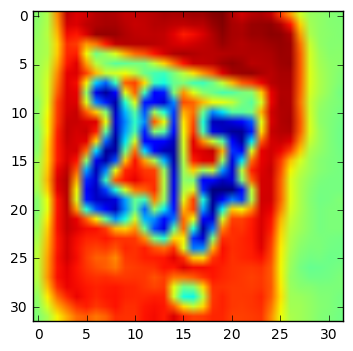

In [8]:
image = np.array(extra_dataset[np.random.randint(extra_dataset.shape[0]), 0, :, :])
plt.figure()
plt.imshow(image)

In [ ]:
inputs = Input(shape=(num_channels, image_size, image_size))

c1 = Convolution2D(64, 5, 5, border_mode='same')(inputs) # Originally 48
a1 = Activation('relu')(c1)
mp1 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a1)
bn1 = BatchNormalization()(mp1)

c2 = Convolution2D(96, 5, 5, border_mode='same')(bn1) # Originally 64
a2 = Activation('relu')(c2)
mp2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a2)
do2 = Dropout(0.25)(mp2)
bn2 = BatchNormalization()(do2)

c3 = Convolution2D(128, 5, 5, border_mode='same')(bn2)
a3 = Activation('relu')(c3)
mp3 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a3)
do3 = Dropout(0.25)(mp3)
bn3 = BatchNormalization()(do3)

c4 = Convolution2D(160, 5, 5, border_mode='same')(bn3)
a4 = Activation('relu')(c4)
mp4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a4)
do4 = Dropout(0.25)(mp4)
bn4 = BatchNormalization()(do4)

c5 = Convolution2D(192, 5, 5, border_mode='same')(bn4)
a5 = Activation('relu')(c5)
mp5 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a5)
do5 = Dropout(0.25)(mp5)
bn5 = BatchNormalization()(do5)

c6 = Convolution2D(192, 5, 5, border_mode='same')(bn5)
a6 = Activation('relu')(c6)
mp6 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a6)
do6 = Dropout(0.25)(mp6)
bn6 = BatchNormalization()(do6)

c7 = Convolution2D(192, 5, 5, border_mode='same')(bn6)
a7 = Activation('relu')(c7)
mp7 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), border_mode='same')(a7)
do7 = Dropout(0.25)(mp7)
bn7 = BatchNormalization()(do7)

c8 = Convolution2D(192, 5, 5, border_mode='same')(bn7)
a8 = Activation('relu')(c8)
mp8 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same')(a8)
do8 = Dropout(0.25)(mp8)
bn8 = BatchNormalization()(do8)

fl = Flatten()(bn8)

d1 = Dense(1024)(fl)
a9 = Activation('relu')(d1)
do9 = Dropout(0.25)(a9)
bn9 = BatchNormalization()(do9)

d3 = Dense(max_sequence_length)(bn9)
bn10 = BatchNormalization()(d3)
L = Activation('softmax')(bn10) # <--- Sequence length representation

d4 = Dense(num_labels)(bn9)
bn11 = BatchNormalization()(d4)
S1 = Activation('softmax')(bn11) # First character/digit

d5 = Dense(num_labels)(bn9)
bn12 = BatchNormalization()(d5)
S2 = Activation('softmax')(bn12)

d6 = Dense(num_labels)(bn9)
bn13 = BatchNormalization()(d6)
S3 = Activation('softmax')(bn13)

d7 = Dense(num_labels)(bn9)
bn14 = BatchNormalization()(d7)
S4 = Activation('softmax')(bn14)

d8 = Dense(num_labels)(bn9)
bn15 = BatchNormalization()(d8)
S5 = Activation('softmax')(bn15)

clf = Model(input=inputs, output=[L, S1, S2, S3, S4, S5]) # Seq length + five channel output

clf.compile(loss='categorical_crossentropy', optimizer='adadelta', 
            metrics=['categorical_accuracy'])

clf.fit(train_dataset, [train_sequences, train_labels[:,:,0], train_labels[:,:,1], train_labels[:,:,2], 
                        train_labels[:,:,3], train_labels[:,:,4]
                       ], batch_size=100, nb_epoch=100, validation_split=0.03)

# clf.fit(extra_dataset, [extra_sequences, extra_labels[:,:,0], extra_labels[:,:,1], extra_labels[:,:,2], 
#                         extra_labels[:,:,3], extra_labels[:,:,4]
#                        ], batch_size=100, nb_epoch=10, validation_split=0.03)

clf.save('SVHN-8.h5')

Train on 32398 samples, validate on 1003 samples
Epoch 1/100
32398/32398 [==============================] - 19s - loss: 13.9242 - activation_87_loss: 1.5827 - activation_88_loss: 2.5600 - activation_89_loss: 2.4955 - activation_90_loss: 2.4735 - activation_91_loss: 2.4142 - activation_92_loss: 2.3983 - activation_87_categorical_accuracy: 0.3911 - activation_88_categorical_accuracy: 0.1153 - activation_89_categorical_accuracy: 0.1232 - activation_90_categorical_accuracy: 0.1479 - activation_91_categorical_accuracy: 0.2094 - activation_92_categorical_accuracy: 0.5130 - val_loss: 13.6032 - val_activation_87_loss: 1.7553 - val_activation_88_loss: 2.4600 - val_activation_89_loss: 2.6088 - val_activation_90_loss: 2.2810 - val_activation_91_loss: 2.2818 - val_activation_92_loss: 2.2162 - val_activation_87_categorical_accuracy: 0.3579 - val_activation_88_categorical_accuracy: 0.1864 - val_activation_89_categorical_accuracy: 0.1655 - val_activation_90_categorical_accuracy: 0.1874 - val_activati

In [37]:
clf = load_model('SVHN-1.h5') # Train dataset, conv: [48, 64, 128, 160], dense: 1024, 40 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

13068/13068 [==============================] - 9s     

 [5.4023998311290615, 0.89545653230887801, 1.5376569079009992, 1.9811692382350112, 0.88891074060481512, 0.097007146513960141, 0.0021992563879725136, 0.59825528010995077, 0.48278236914600553, 0.33379247015610652, 0.81802877259247153, 0.98813896541169266, 0.99984695439240889]

 0.17393633302724212


In [38]:
clf = load_model('SVHN-2.h5') # Extra dataset, conv: [48, 64, 128, 160], dense: 1024, 10 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

13068/13068 [==============================] - 9s     

 [5.3829847497242396, 0.79433079940082463, 1.6010016901324493, 2.103443737018353, 0.79029882971321652, 0.091895836446506091, 0.0020138699997727877, 0.68992959903875262, 0.47497704317710582, 0.27578818487909396, 0.82024793390254203, 0.98836853382307932, 0.99984695439240889]

 0.14072543617998162


In [39]:
clf = load_model('SVHN-3.h5') # Extra dataset, conv: [48, 64, 128, 160], dense: 3096, 10 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

13068/13068 [==============================] - 10s    

 [5.4958253646794537, 0.83648692247952972, 1.6547261319249493, 2.0859525640842049, 0.82337394244524187, 0.093327031160964496, 0.0019587966610032856, 0.66819712277906618, 0.44872972146611639, 0.28466483012393667, 0.81290174473817101, 0.98806244260789711, 0.99984695439240889]

 0.14776553412917048


In [6]:
clf = load_model('SVHN-4.h5') # Train dataset, conv: [64, 96, 128, 160], dense: 1024, 40 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

13068/13068 [==============================] - 4s     

 [5.3566485807222071, 0.90016449924488839, 1.5096203635729231, 1.9428244316508583, 0.9062082461527009, 0.095636448673253979, 0.002194597963731192, 0.60108662385038547, 0.49464340374343507, 0.35445362718546103, 0.80517294155482233, 0.98806244260789711, 0.99984695439240889]

 0.19344964799510253


In [8]:
clf = load_model('SVHN-5.h5') # Extra dataset, conv: [64, 96, 128, 160], dense: 1024, 10 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

13068/13068 [==============================] - 5s     

 [5.3647891287778835, 0.81150033731580251, 1.5841829306056896, 2.0719198378576649, 0.80267874876001322, 0.092408624945198733, 0.0020986455578908877, 0.67638506276694355, 0.48270584635133224, 0.29040404041316265, 0.8161922253013788, 0.98790939700030611, 0.99984695439240889]

 0.1605448423630242


In [10]:
clf = load_model('SVHN-6.h5') # Extra? dataset, conv: [64, 96, 128, 160], dense: 1024, 100 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

13068/13068 [==============================] - 5s     

 [5.3822789122140984, 1.022771981775414, 1.4367137944110862, 1.8509641392427298, 0.9710760029368638, 0.098779990443549903, 0.0019730056232501523, 0.56718702173247626, 0.51729415369427889, 0.39623507806238212, 0.77701254975806688, 0.98699112335475969, 0.99984695439240889]

 0.23752678298132843


In [14]:
clf = load_model('SVHN-7.h5') # Extra dataset, four digits, conv: [64, 96, 128, 160], dense: 1024, 10 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3]]) # , test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences, False))

13056/13066 [============================>.] - ETA: 0s
 [5.9029104382999451, 0.99733911769670747, 1.6613468179362629, 2.1789863711382953, 0.95013083516410968, 0.11510726918329392, 0.56934027246288077, 0.45660492882518006, 0.25179856115107913, 0.79488749424166394, 0.98652992499617331]

 0.1165620694933415


In [22]:
clf = load_model('SVHN-8.h5') # Test dataset, conv: [64, 96, 128, 160], dense: [1024, 32], 100 epochs
# clf.summary()

evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])

print("\n", evaluate)

print("\n", getAccuracy(clf, test_dataset, test_sequences))

13068/13068 [==============================] - 6s     

 [5.6521925035878935, 1.0234676511564276, 1.4769880512565656, 2.0100597023124682, 1.0395258394884415, 0.10031086809529527, 0.001840389468449869, 0.57468625652268279, 0.50826446282816184, 0.32177838996020813, 0.76714110806844338, 0.98660850933578204, 0.99984695439240889]

 0.17408937863483318


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** To prepare the training and testing data, I looped through all of the files in the two directories and pulled each image's sequence information from the digitStruct files. To make the images consistent, I resized them all to 32x32 and also converted them to greyscale.

Using the same model that achieved almost 90% accuracy on the previous dataset, the SVHN data was only able to produce an accuracy of 17.4%.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** Considering the very low number of 5-digit examples in the training set, I thought that perhaps the training data isn't adequate, so I began using the larger "extra" dataset. However, the current model seemed to struggle to converge on the data and only produced an accuracy of 14.1%.

Next I increased the size of the hidden layer to allow the model to become more complex, but the accuracy only increased by a very small amount (14.8%).

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** Initial result: % accuracy. Final result: % accuracy. This model is still not doing a good enough job at classifying numbers correctly.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
## Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.